# Forecasting & Portfolio Simulation

- Loads a set of S&P 500 tickers from CSV
- Downloads daily prices via yfinance
- Visualizes prices and returns
- Builds a multivariate time series (Darts)
- Trains rolling forecasts (LightGBM, LinearRegression)
- Runs a daily long-only minimum-variance optimization using predicted returns
- Benchmarks against historical-average-returns optimization
- Evaluates with wealth curve and Sharpe ratio


## Setup & Requirements

Make sure these packages are installed (adjust versions as needed):

```bash
pip install pandas numpy matplotlib seaborn tqdm yfinance
pip install u8darts[all]
pip install lightgbm
pip install cvxpy ecos
```

Ensure `sp500_companies.csv` is in the same folder with at least a `Symbol` column.


In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from tqdm import tqdm
import yfinance as yf

from darts import TimeSeries, concatenate
from darts.utils.missing_values import fill_missing_values
from darts.metrics import mae, mape, rmse
from darts.models import LightGBMModel, LinearRegressionModel

import cvxpy as cp

plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.width', 160)
pd.set_option('display.max_columns', 50)


Support for Torch based models not available. To enable them, install "darts", "u8darts[torch]" or "u8darts[all]" (with pip); or "u8darts-torch" or "u8darts-all" (with conda).


In [36]:
# Configuration
CSV_PATH = 'sp500_companies.csv'
N_TICKERS = 50
START_DATE = '2024-01-01'

# Forecasting params
INITIAL_WINDOW = 30
TRAIN_LENGTH = 30
HORIZON = 1
LAGS_LGBM = 12
LAGS_LR = 10

# Optimization params
REQ_RETURN = 0.005  # minimum expected daily return
W_MAX = 0.50 # minimum portfolio weight


In [3]:
# Load tickers from CSV
sp500_list_df = pd.read_csv(CSV_PATH)
tickers = (sp500_list_df['Symbol']
           .dropna()
           .astype(str)
           .head(N_TICKERS)
           .tolist())
len(tickers), tickers[:10]

(50,
 ['AAPL',
  'NVDA',
  'MSFT',
  'AMZN',
  'GOOGL',
  'GOOG',
  'META',
  'TSLA',
  'AVGO',
  'BRK-B'])

In [4]:
# Download daily prices via yfinance
data_raw = yf.download(tickers, start=START_DATE, auto_adjust=False, progress=False, threads=True)

# Extract close prices into a clean DataFrame
if isinstance(data_raw.columns, pd.MultiIndex):
    close = data_raw['Close'].copy()
else:
    # If single ticker or already flattened
    if 'Close' in data_raw.columns:
        close = data_raw[['Close']].copy()
        close.columns = tickers[:1]
    else:
        close = data_raw.copy()

# Basic cleaning
close = close.dropna(how='all').sort_index()
close = close.ffill()

# Keep a pandas DataFrame with Date as column for Darts
data = close.reset_index().rename(columns={'Date': 'Date'})
data['Date'] = pd.to_datetime(data['Date'])
value_cols = [c for c in data.columns if c != 'Date']
data.head()

Ticker,Date,AAPL,ABBV,ABT,ACN,ADBE,AMD,AMZN,AVGO,AXP,BAC,BRK-B,BX,COST,CRM,CSCO,CVX,DIS,GE,GOOG,GOOGL,HD,IBM,ISRG,JNJ,...,KO,LIN,LLY,MA,MCD,META,MRK,MS,MSFT,NFLX,NOW,NVDA,ORCL,PEP,PG,PLTR,PM,TMO,TMUS,TSLA,UNH,V,WFC,WMT,XOM
0,2024-01-02,185.639999,159.820007,109.849998,346.920013,580.070007,138.580002,149.929993,108.538002,188.309998,33.900002,362.459991,128.270004,650.650024,256.130005,50.509998,149.479996,90.709999,100.518753,139.559998,138.169998,345.079987,161.500000,330.980011,159.970001,...,59.820000,409.579987,592.200012,421.890015,297.040009,346.290009,113.239998,93.900002,370.869995,468.500000,687.520020,48.167999,104.059998,172.910004,148.740005,16.58,95.559998,544.150024,161.910004,248.419998,539.340027,258.869995,49.330002,53.096668,102.360001
1,2024-01-03,184.250000,160.460007,109.519997,337.920013,571.789978,135.320007,148.470001,105.858002,186.320007,33.529999,366.750000,122.349998,644.690002,251.839996,50.509998,152.330002,91.650002,99.010376,140.360001,138.919998,338.260010,160.100006,322.130005,160.970001,...,59.959999,408.709991,617.700012,418.769989,294.390015,344.470001,114.769997,91.910004,370.600006,470.260010,675.299988,47.569000,102.459999,172.949997,147.839996,16.09,95.419998,528.820007,162.080002,238.449997,542.030029,257.980011,48.680000,53.099998,103.220001
2,2024-01-04,181.910004,161.460007,110.980003,337.089996,567.049988,136.009995,144.570007,104.901001,187.139999,33.799999,363.679993,122.900002,648.349976,251.240005,50.080002,150.660004,90.559998,99.489227,138.039993,136.389999,338.589996,160.860001,323.269989,160.630005,...,59.759998,408.589996,614.500000,419.769989,291.739990,347.119995,117.010002,92.150002,367.940002,474.670013,671.869995,47.998001,102.589996,171.470001,148.649994,16.25,95.660004,537.359985,162.300003,237.929993,545.419983,259.609985,49.279999,52.586666,102.320000
3,2024-01-05,181.179993,162.139999,110.800003,336.619995,564.599976,138.580002,145.240005,104.928001,189.059998,34.430000,365.589996,122.209999,656.010010,251.119995,50.090000,150.399994,90.900002,100.790108,137.389999,135.729996,342.940002,159.160004,322.500000,161.130005,...,59.669998,409.119995,618.549988,419.420013,288.989990,351.950012,117.220001,93.239998,367.750000,474.059998,676.159973,49.097000,102.730003,168.940002,147.419998,15.98,95.300003,531.229980,163.369995,237.490005,537.380005,259.690002,49.919998,52.236668,102.629997
4,2024-01-08,185.559998,161.429993,112.400002,340.350006,580.549988,146.179993,149.100006,107.485001,189.210007,34.160000,368.179993,122.339996,661.690002,260.869995,50.459999,149.500000,91.550003,102.378288,140.529999,138.839996,347.929993,161.139999,328.859985,161.529999,...,60.110001,408.290009,626.030029,421.980011,291.899994,358.660004,117.379997,93.510002,374.690002,485.029999,696.260010,52.252998,104.660004,169.110001,148.690002,16.67,96.290001,541.380005,163.410004,240.449997,536.520020,262.540009,49.919998,52.750000,100.919998


## Visualize Prices & Returns
Quick sanity checks and exploratory visuals on the downloaded data.


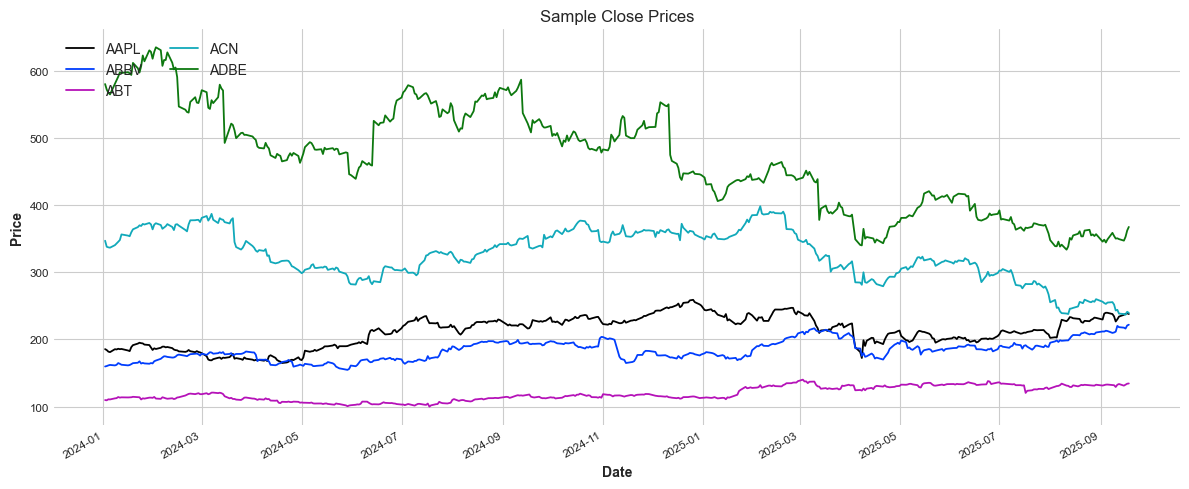

In [7]:
# Plot a few sample tickers' price series
sample = value_cols[:5]
fig, ax = plt.subplots(figsize=(12, 5))
close[sample].plot(ax=ax)
ax.set_title('Sample Close Prices')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend(loc='upper left', ncol=2)
plt.tight_layout()
plt.show()

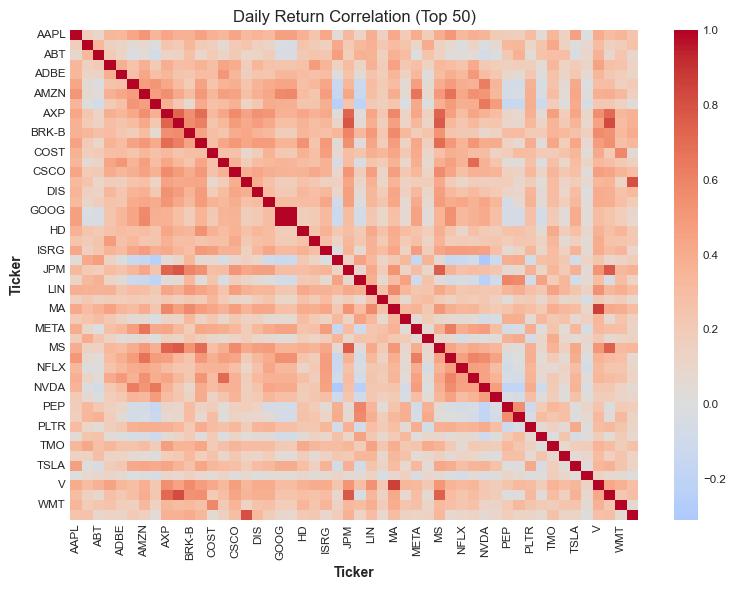

In [8]:
# Return correlation heatmap
returns = close.pct_change().dropna(how='all')
corr = returns.corr()
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr, cmap='coolwarm', center=0.0, ax=ax)
ax.set_title('Daily Return Correlation (Top 50)')
plt.tight_layout()
plt.show()

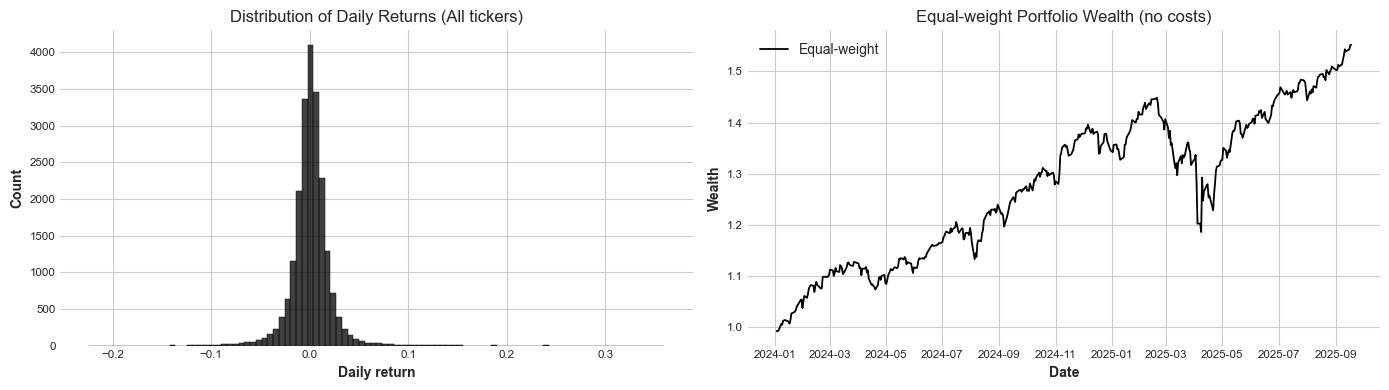

In [9]:
# Distribution of daily returns (stacked across tickers) and equal-weight cum return
long_ret = returns.melt(ignore_index=False, var_name='ticker', value_name='ret').dropna()
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
sns.histplot(long_ret['ret'], bins=100, ax=axes[0])
axes[0].set_title('Distribution of Daily Returns (All tickers)')
axes[0].set_xlabel('Daily return')

ew_ret = returns.mean(axis=1).fillna(0)
ew_cum = (1.0 + ew_ret).cumprod()
axes[1].plot(ew_cum.index, ew_cum.values, label='Equal-weight')
axes[1].set_title('Equal-weight Portfolio Wealth (no costs)')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Wealth')
axes[1].legend()
plt.tight_layout()
plt.show()

## Build Darts TimeSeries
Create a multivariate series of close prices (daily frequency) and fill missing values.


In [5]:
series_multi = TimeSeries.from_dataframe(data, time_col='Date', value_cols=value_cols, freq='D')
series_multi = fill_missing_values(series_multi)
series_multi

<TimeSeries (DataArray) (Date: 626, component: 50, sample: 1)> Size: 250kB
array([[[185.63999939],
        [159.82000732],
        [109.84999847],
        ...,
        [ 49.33000183],
        [ 53.09666824],
        [102.36000061]],

       [[184.25      ],
        [160.46000671],
        [109.51999664],
        ...,
        [ 48.68000031],
        [ 53.09999847],
        [103.22000122]],

       [[181.91000366],
        [161.46000671],
        [110.98000336],
        ...,
...
        ...,
        [ 81.38999939],
        [103.41999817],
        [114.68000031]],

       [[238.99000549],
        [220.80999756],
        [134.16999817],
        ...,
        [ 82.48000336],
        [104.26999664],
        [115.29000092]],

       [[237.88000488],
        [221.99000549],
        [134.57000732],
        ...,
        [ 83.5       ],
        [103.59999847],
        [113.93000031]]])
Coordinates:
  * Date       (Date) datetime64[ns] 5kB 2024-01-02 2024-01-03 ... 2025-09-18
  * component  (component) object 400B 'AAPL' 'ABBV' 'ABT' ... 'WFC' 'WMT' 'XOM'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

## Forecasting Helpers
Utility for rolling 1-step forecasts and metrics.


In [6]:
def run_model(model, series_multi, initial_window=INITIAL_WINDOW, train_length=TRAIN_LENGTH, h=HORIZON):
    pred_list = model.historical_forecasts(
        series_multi,
        start=series_multi.time_index[initial_window],
        forecast_horizon=h,
        stride=1,
        retrain=True,
        verbose=False,
        train_length=train_length
    )
    pred = concatenate(pred_list)
    actual = series_multi.slice_intersect(pred)
    pred = pred.slice_intersect(actual)

    metrics = {
        'MAE': float(mae(actual, pred)),
        'MAPE_%': float(mape(actual, pred)),
        'RMSE': float(rmse(actual, pred)),
    }
    pred_df = pred.pd_dataframe().reset_index()
    return pred_df, metrics

def print_metrics(name, metrics):
    print(f'{name} metrics:')
    for k, v in metrics.items():
        if k == 'MAPE_%':
            print(f'  {k}: {v:.4f}%')
        else:
            print(f'  {k}: {v:.6f}')


## Run Forecasts (LightGBM)

In [7]:
lgbm = LightGBMModel(lags=LAGS_LGBM, verbose=-1)
pred_df_lgbm, metrics_lgbm = run_model(lgbm, series_multi)
print_metrics('LightGBM', metrics_lgbm)
pred_df_lgbm.head()

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


LightGBM metrics:
  MAE: 8.279561
  MAPE_%: 2.9304%
  RMSE: 10.987654


component,time,AAPL,ABBV,ABT,ACN,ADBE,AMD,AMZN,AVGO,AXP,BAC,BRK-B,BX,COST,CRM,CSCO,CVX,DIS,GE,GOOG,GOOGL,HD,IBM,ISRG,JNJ,...,KO,LIN,LLY,MA,MCD,META,MRK,MS,MSFT,NFLX,NOW,NVDA,ORCL,PEP,PG,PLTR,PM,TMO,TMUS,TSLA,UNH,V,WFC,WMT,XOM
0,2024-02-01,189.967081,164.087777,113.437778,365.285970,609.586945,169.538610,156.201387,118.855779,189.427361,32.886667,373.032776,121.627083,689.091251,278.610275,51.388472,145.429169,94.265277,103.907289,148.687778,147.102779,355.896111,176.694444,372.216390,160.367917,...,59.707223,406.031806,635.069024,436.872918,295.148054,385.122918,119.687499,86.613750,399.053333,520.739438,756.029717,59.638166,111.010138,166.927500,152.214862,16.753472,92.338888,548.162784,163.266946,203.067500,510.365558,270.167642,48.805833,54.343657,99.758055
1,2024-02-02,190.082915,164.401666,113.473889,366.145137,611.298055,170.529165,156.500832,119.348501,190.633749,32.947222,374.370555,121.932917,690.319862,279.345830,51.372639,145.563057,94.563055,104.196816,148.607223,147.024445,356.062778,177.834444,373.372501,160.195972,...,59.751111,406.079861,636.273746,438.661530,295.470276,386.445419,120.121943,86.557362,399.853889,525.228882,758.398051,60.053778,111.507083,167.204166,152.714027,16.735972,92.250000,548.666670,163.249724,201.370834,509.632780,270.853473,48.895833,54.468380,99.956389
2,2024-02-03,190.174443,164.788333,113.380000,367.142220,613.373888,171.749443,157.516665,119.966278,192.032221,33.012778,375.982776,122.257222,691.850555,280.222775,51.353334,145.988335,94.827222,104.556620,148.575000,147.016112,356.033890,178.896665,374.544445,159.952777,...,59.776111,406.072778,637.995555,440.441667,295.768331,392.321669,120.559999,86.577778,401.042777,529.710549,761.361108,60.620222,112.018888,167.455555,153.163889,16.760000,92.155000,549.180003,163.185001,199.607223,509.104448,271.531667,49.017777,54.614074,100.162777
3,2024-02-04,190.331665,165.235740,113.279815,368.115555,615.355001,172.737035,158.524998,120.608685,193.436852,33.078889,377.630183,122.539074,693.436666,281.183144,51.318148,146.465001,95.044999,104.953889,148.570741,147.034075,355.928521,179.898887,375.738705,159.720555,...,59.797408,405.977593,640.547221,442.161482,295.894257,398.007039,120.995740,86.624445,402.103519,534.296107,764.412218,61.222186,112.542221,167.721296,153.627223,16.781667,92.045370,549.721856,163.117037,197.702593,508.474262,272.165371,49.139259,54.751790,100.392777
4,2024-02-05,190.575554,165.699999,113.161667,369.091110,617.345001,173.581665,159.586109,121.348556,194.831111,33.153889,379.378332,122.833889,694.903887,282.063885,51.286667,146.975002,95.404444,105.416778,148.658333,147.132779,355.936113,180.906108,377.127779,159.478333,...,59.809445,405.757222,644.127224,443.862222,295.811108,403.353336,121.447222,86.732222,403.105555,538.884440,767.529999,61.901167,113.084444,167.971110,154.084445,16.805556,91.954999,550.412781,162.987222,195.913333,507.387780,272.692222,49.260555,54.897963,100.654444


In [8]:
lr = LinearRegressionModel(lags=LAGS_LR)
pred_df_lr, metrics_lr = run_model(lr, series_multi)
print_metrics('LinearRegression', metrics_lr)


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


LinearRegression metrics:
  MAE: 3.317394
  MAPE_%: 1.1709%
  RMSE: 5.196857


### Forecast Overlay (one sample ticker)
Overlay actual vs. predicted for a single ticker to visually inspect forecast timing.


In [9]:
pred_df_lgbm

component,time,AAPL,ABBV,ABT,ACN,ADBE,AMD,AMZN,AVGO,AXP,BAC,BRK-B,BX,COST,CRM,CSCO,CVX,DIS,GE,GOOG,GOOGL,HD,IBM,ISRG,JNJ,...,KO,LIN,LLY,MA,MCD,META,MRK,MS,MSFT,NFLX,NOW,NVDA,ORCL,PEP,PG,PLTR,PM,TMO,TMUS,TSLA,UNH,V,WFC,WMT,XOM
0,2024-02-01,189.967081,164.087777,113.437778,365.285970,609.586945,169.538610,156.201387,118.855779,189.427361,32.886667,373.032776,121.627083,689.091251,278.610275,51.388472,145.429169,94.265277,103.907289,148.687778,147.102779,355.896111,176.694444,372.216390,160.367917,...,59.707223,406.031806,635.069024,436.872918,295.148054,385.122918,119.687499,86.613750,399.053333,520.739438,756.029717,59.638166,111.010138,166.927500,152.214862,16.753472,92.338888,548.162784,163.266946,203.067500,510.365558,270.167642,48.805833,54.343657,99.758055
1,2024-02-02,190.082915,164.401666,113.473889,366.145137,611.298055,170.529165,156.500832,119.348501,190.633749,32.947222,374.370555,121.932917,690.319862,279.345830,51.372639,145.563057,94.563055,104.196816,148.607223,147.024445,356.062778,177.834444,373.372501,160.195972,...,59.751111,406.079861,636.273746,438.661530,295.470276,386.445419,120.121943,86.557362,399.853889,525.228882,758.398051,60.053778,111.507083,167.204166,152.714027,16.735972,92.250000,548.666670,163.249724,201.370834,509.632780,270.853473,48.895833,54.468380,99.956389
2,2024-02-03,190.174443,164.788333,113.380000,367.142220,613.373888,171.749443,157.516665,119.966278,192.032221,33.012778,375.982776,122.257222,691.850555,280.222775,51.353334,145.988335,94.827222,104.556620,148.575000,147.016112,356.033890,178.896665,374.544445,159.952777,...,59.776111,406.072778,637.995555,440.441667,295.768331,392.321669,120.559999,86.577778,401.042777,529.710549,761.361108,60.620222,112.018888,167.455555,153.163889,16.760000,92.155000,549.180003,163.185001,199.607223,509.104448,271.531667,49.017777,54.614074,100.162777
3,2024-02-04,190.331665,165.235740,113.279815,368.115555,615.355001,172.737035,158.524998,120.608685,193.436852,33.078889,377.630183,122.539074,693.436666,281.183144,51.318148,146.465001,95.044999,104.953889,148.570741,147.034075,355.928521,179.898887,375.738705,159.720555,...,59.797408,405.977593,640.547221,442.161482,295.894257,398.007039,120.995740,86.624445,402.103519,534.296107,764.412218,61.222186,112.542221,167.721296,153.627223,16.781667,92.045370,549.721856,163.117037,197.702593,508.474262,272.165371,49.139259,54.751790,100.392777
4,2024-02-05,190.575554,165.699999,113.161667,369.091110,617.345001,173.581665,159.586109,121.348556,194.831111,33.153889,379.378332,122.833889,694.903887,282.063885,51.286667,146.975002,95.404444,105.416778,148.658333,147.132779,355.936113,180.906108,377.127779,159.478333,...,59.809445,405.757222,644.127224,443.862222,295.811108,403.353336,121.447222,86.732222,403.105555,538.884440,767.529999,61.901167,113.084444,167.971110,154.084445,16.805556,91.954999,550.412781,162.987222,195.913333,507.387780,272.692222,49.260555,54.897963,100.654444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591,2025-09-14,233.959816,212.225368,132.167777,252.659817,351.496760,159.229910,230.582962,325.253430,327.305552,50.291297,498.213147,173.260649,956.068336,250.574166,67.761018,157.826761,117.727314,277.826206,227.405557,226.954631,413.497036,249.132129,463.213052,177.630275,...,68.188240,476.135839,739.882507,588.521098,312.290002,747.833988,84.217963,150.910461,503.724169,1225.978685,920.698520,173.221481,247.727498,146.097870,158.138241,159.169259,164.881944,487.257684,248.610555,348.939165,321.898612,346.226013,81.007408,99.867316,112.260742
592,2025-09-15,234.256112,212.769442,132.204999,251.602780,351.024723,158.850281,230.650554,328.721948,327.536109,50.302778,498.021666,173.890834,956.800557,250.154166,67.673055,157.715835,117.596388,278.478058,229.632779,229.206112,414.300556,249.713610,461.439163,177.676387,...,68.0

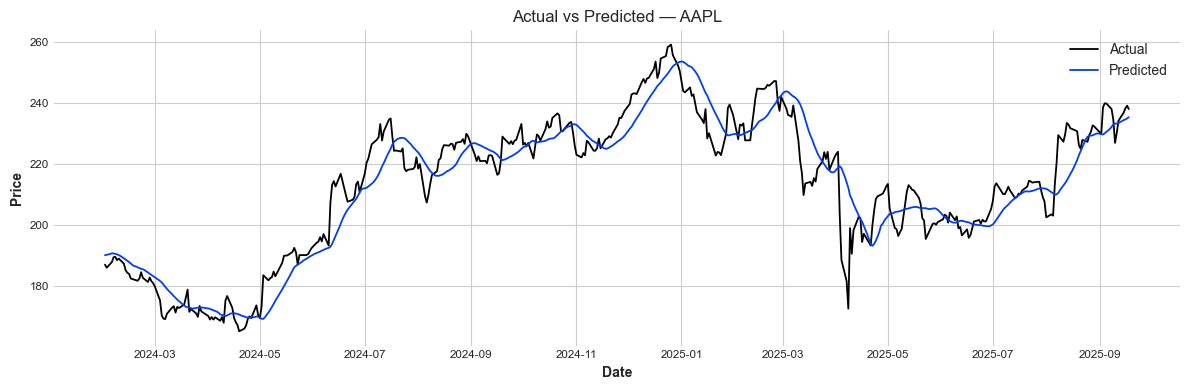

In [10]:
sample_ticker = value_cols[0] if len(value_cols) > 0 else None
if sample_ticker is not None:
    # Align actual and predicted for the sample ticker
    actual_df = series_multi.pd_dataframe().reset_index()
    merged = (actual_df[['Date', sample_ticker]]
              .merge(pred_df_lgbm[['time', sample_ticker]], left_on="Date", right_on='time', how='inner', suffixes=('_actual', '_pred')))
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(merged['time'], merged[f'{sample_ticker}_actual'], label='Actual')
    ax.plot(merged['time'], merged[f'{sample_ticker}_pred'], label='Predicted')
    ax.set_title(f'Actual vs Predicted — {sample_ticker}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print('No tickers available to plot.')


## Portfolio Optimization
Daily long-only minimum-variance with a minimum expected return constraint.
- Predicted strategy: expected returns from the forecast (t → t+1).
- Benchmark: expected returns from historical average (no model).


In [54]:
def simulate_with_predictions(data_df, value_cols, pred_df, req_return=REQ_RETURN, initial_window=INITIAL_WINDOW, max_weight=W_MAX):
    # We will iterate over simulation dates aligned to the forecasting window
    # Choose dates starting a bit after initial_window to allow covariance estimation
    # Align on calendar dates present in data_df
    date_sim = data_df[data_df['Date'] >= series_multi.time_index[initial_window+TRAIN_LENGTH]].Date.values

    solutions = []
    rows = []

    # For covariance, use trailing historical returns up to 'date'
    for date in tqdm(date_sim[:-1]):
        # Covariance of historical daily returns up to 'date'
        df_hist = (data_df[data_df['Date'] <= date]
                   .sort_values('Date', ascending=False)[value_cols]
                   .pct_change()
                   .dropna())
        if df_hist.shape[0] < 2:
            # Not enough history to form a covariance matrix
            if solutions:
                solutions.append(solutions[-1])
            continue
        C = df_hist.cov()
        n = len(value_cols)
        x = cp.Variable(n)

        # Predicted t→t+1 return vector using price delta from pred_df
        r0 = data_df[data_df['Date'] == date][value_cols].values
        r1 = pred_df[pred_df['time'] == pd.to_datetime(date) + timedelta(days=1)].values[:, 1:]
        if r0.size == 0 or r1.size == 0:
            if solutions:
                solutions.append(solutions[-1])
            continue
        r_pred = (r1 - r0) / r0
        ret = r_pred @ x
        risk = cp.quad_form(x, C.values)

        constraints = [cp.sum(x) == 1, x >= 0, ret >= req_return, x <= max_weight]
        prob = cp.Problem(cp.Minimize(risk), constraints)
        try:
            prob.solve(solver='ECOS')
            if x.value is None:
                raise ValueError('No solution')
            solutions.append(x.value)
        except Exception:
            # Fallback to previous solution if solver fails
            if solutions:
                solutions.append(solutions[-1])

    # Realized returns using next-day actuals
    simulated_data = data_df[data_df['Date'] >= min(date_sim[:-1])]
    for i, date in enumerate(simulated_data.Date.values[:-1]):
        now = simulated_data.loc[simulated_data['Date'] == date, value_cols]
        next_day = simulated_data.loc[simulated_data['Date'] == pd.to_datetime(date) + timedelta(days=1), value_cols]
        if len(next_day) == 0:
            continue
        r = (next_day.values.squeeze() / now.values.squeeze()) - 1.0
        w = solutions[i] if i < len(solutions) else np.ones(len(value_cols))/len(value_cols)
        realized_return = float(np.dot(r, w))
        row = {'Date': pd.to_datetime(date), 'port_ret': realized_return, 'proportion':dict(zip(value_cols, w))}
        rows.append(row)

    trades_df = pd.DataFrame(rows).sort_values('Date').reset_index(drop=True)
    if not trades_df.empty:
        trades_df['wealth'] = (1.0 + trades_df['port_ret']).cumprod()
        trades_df['cum_return'] = trades_df['wealth'] - 1.0
        excess = trades_df['port_ret']  # rf assumed 0
        sharpe = (excess.mean() / excess.std(ddof=1)) * np.sqrt(252) if excess.std(ddof=1) != 0 else np.nan
    else:
        sharpe = np.nan
    return trades_df, sharpe

def simulate_benchmark_hist_mean(data_df, value_cols, req_return=REQ_RETURN, initial_window=INITIAL_WINDOW, max_weight=W_MAX):
    date_sim = data_df[data_df['Date'] >= series_multi.time_index[initial_window+TRAIN_LENGTH]].Date.values
    solutions = []
    rows = []

    for date in tqdm(date_sim[:-1]):
        df_hist = (data_df[data_df['Date'] <= date]
                   .sort_values('Date', ascending=False)[value_cols]
                   .pct_change()
                   .dropna())
        if df_hist.shape[0] < 2:
            if solutions:
                solutions.append(solutions[-1])
            continue
        C = df_hist.cov()
        r_hist_mean = df_hist.mean().values
        n = len(value_cols)
        x = cp.Variable(n)
        ret = r_hist_mean @ x
        risk = cp.quad_form(x, C.values)
        constraints = [cp.sum(x) == 1, x >= 0, ret >= req_return, x <= max_weight]
        prob = cp.Problem(cp.Minimize(risk), constraints)
        try:
            prob.solve(solver='ECOS')
            if x.value is None:
                raise ValueError('No solution')
            solutions.append(x.value)
        except Exception:
            if solutions:
                solutions.append(solutions[-1])

    simulated_data = data_df[data_df['Date'] >= min(date_sim[:-1])]
    for i, date in enumerate(simulated_data.Date.values[:-1]):
        now = simulated_data.loc[simulated_data['Date'] == date, value_cols]
        next_day = simulated_data.loc[simulated_data['Date'] == pd.to_datetime(date) + timedelta(days=1), value_cols]
        if len(next_day) == 0:
            continue
        r = (next_day.values.squeeze() / now.values.squeeze()) - 1.0
        w = solutions[i] if i < len(solutions) else np.ones(len(value_cols))/len(value_cols)
        realized_return = float(np.dot(r, w))
        rows.append({'Date': pd.to_datetime(date), 'port_ret': realized_return, 'proportion':dict(zip(value_cols, w))})

    trades_df = pd.DataFrame(rows).sort_values('Date').reset_index(drop=True)
    if not trades_df.empty:
        trades_df['wealth'] = (1.0 + trades_df['port_ret']).cumprod()
        trades_df['cum_return'] = trades_df['wealth'] - 1.0
        excess = trades_df['port_ret']
        sharpe = (excess.mean() / excess.std(ddof=1)) * np.sqrt(252) if excess.std(ddof=1) != 0 else np.nan
    else:
        sharpe = np.nan
    return trades_df, sharpe


### Run Simulation
Predicted strategy (LightGBM) vs. Linear Regression vs. Historical-mean benchmark.


In [51]:
trades_pred_lgb, sharpe_pred_lgb = simulate_with_predictions(data, value_cols, pred_df_lgbm)
trades_pred_lr, sharpe_pred_lr = simulate_with_predictions(data, value_cols, pred_df_lr)
trades_hist, sharpe_hist = simulate_benchmark_hist_mean(data, value_cols)

print(f'Annualized Sharpe (LGBM): {sharpe_pred_lgb:.4f}')
print(f'Annualized Sharpe (Linear Regression): {sharpe_pred_lr:.4f}')
print(f'Annualized Sharpe (Hist-Mean): {sharpe_hist:.4f}')

100%|██████████| 387/387 [00:07<00:00, 49.81it/s]


Annualized Sharpe (LGBM): 1.6091
Annualized Sharpe (Linear Regression): 1.5637
Annualized Sharpe (Hist-Mean): 0.5128


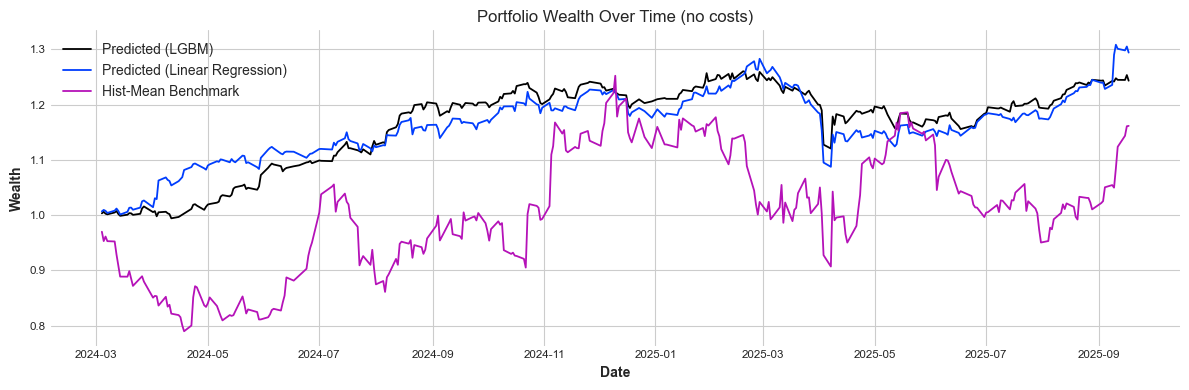

In [52]:
# Wealth curve comparison
fig, ax = plt.subplots(figsize=(12, 4))
if not trades_pred_lgb.empty:
    ax.plot(trades_pred_lgb['Date'], trades_pred_lgb['wealth'], label='Predicted (LGBM)')

if not trades_pred_lr.empty:
    ax.plot(trades_pred_lr['Date'], trades_pred_lr['wealth'], label='Predicted (Linear Regression)')

if not trades_hist.empty:
    ax.plot(trades_hist['Date'], trades_hist['wealth'], label='Hist-Mean Benchmark')
ax.set_title('Portfolio Wealth Over Time (no costs)')
ax.set_xlabel('Date')
ax.set_ylabel('Wealth')
ax.legend()
plt.tight_layout()
plt.show()


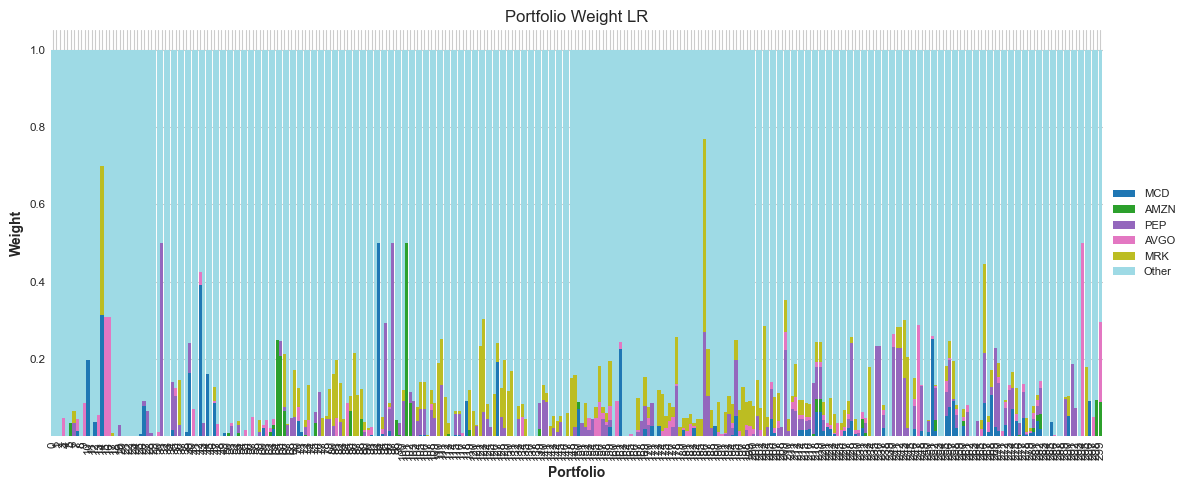

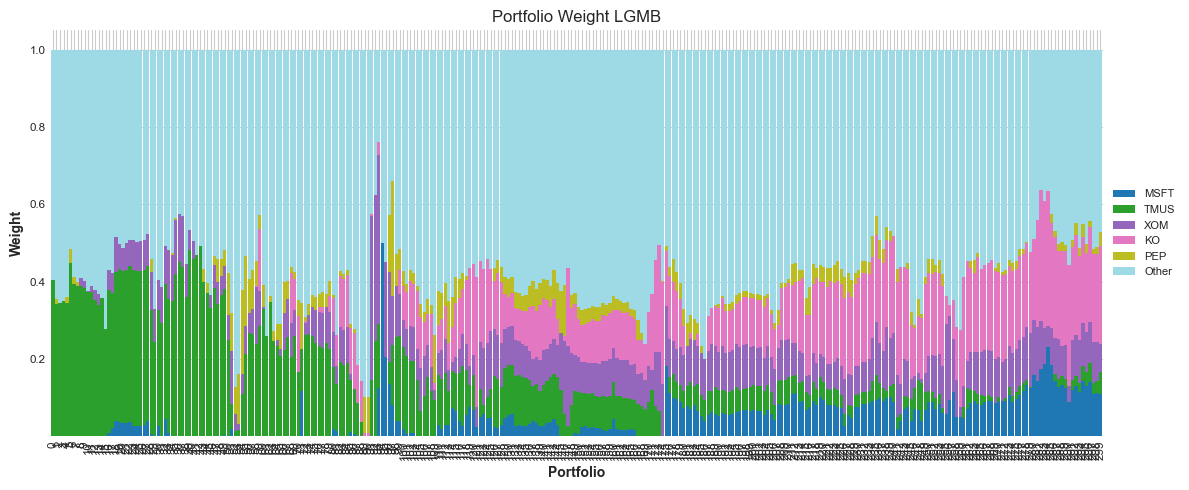

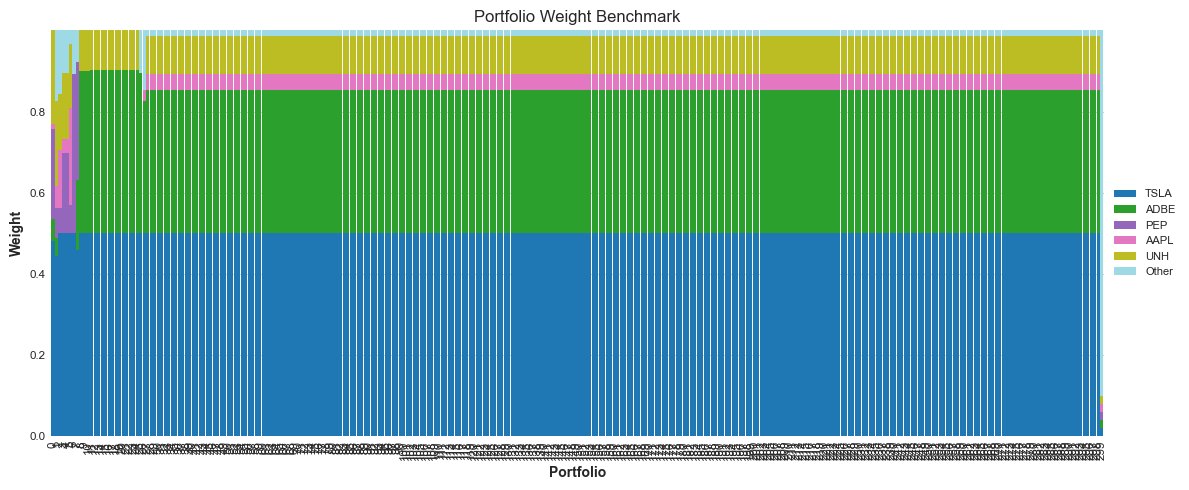

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
from collections.abc import Sequence
import ast

def plot_allocations(allocations, top_k=15, title="Portfolio Weights"):
    # Normalize input to a DataFrame: rows = portfolios, cols = tickers
    if isinstance(allocations, dict):
        df = pd.DataFrame([allocations]).fillna(0)
    elif isinstance(allocations, pd.Series):
        vals = allocations.apply(lambda x: x if isinstance(x, dict) else ast.literal_eval(str(x)))
        df = pd.DataFrame(list(vals)).fillna(0)
        df.index = allocations.index
    elif isinstance(allocations, Sequence):
        df = pd.DataFrame(list(allocations)).fillna(0)
    else:
        raise TypeError("Expected dict, list/Series of dicts")

    # Keep most relevant tickers
    top_cols = df.max().nlargest(top_k).index
    df_plot = df[top_cols].copy()
    other = df.drop(columns=top_cols, errors="ignore").sum(axis=1)
    if (other > 0).any():
        df_plot["Other"] = other

    # Stacked bar chart
    ax = df_plot.plot(kind="bar", stacked=True, figsize=(12, 5), width=0.9, colormap="tab20")
    ax.set_title(title)
    ax.set_xlabel("Portfolio")
    ax.set_ylabel("Weight")
    ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), fontsize=8)
    plt.tight_layout()
    plt.show()

# Example usage (replace `allocations` with your variable)
plot_allocations(trades_pred_lr.proportion, top_k=5, title="Portfolio Weight LR")
plot_allocations(trades_pred_lgb.proportion, top_k=5, title="Portfolio Weight LGMB")
plot_allocations(trades_hist.proportion, top_k=5, title="Portfolio Weight Benchmark")
